The identification of suicidal thoughts in online social networks is a new area of study that faces significant obstacles. Publicly available information shared over social media platforms can be used to accurately identify suicidal persons, according to recent studies in this area. Understanding and recognising the many risk factors and warning signals that might lead to suicide is the most difficult part of suicide prevention. This study provides a method for quantifying suicide warning indicators for people and identifying postings that include suicide-related material on social media. Among the most novel aspects of this method is the automated detection of rapid shifts in a user's online activity. For this, a model framework, which is commonly used to identify changes in data, is employed in combination with natural language processing (NLP) approaches that aggregate behavioural and textual elements.

Import Libraries and Data

In [2]:
import re
import nltk
import pickle
import numpy as np
import collections
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn import tree
from textblob import Word 
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.models import Sequential
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import KFold 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
from keras.layers import Conv1D ,MaxPooling1D
from keras.preprocessing.text import Tokenizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.layers.core import Dropout, Activation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer 
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten
%matplotlib inline



Dataset = pd.read_csv("/Users/Mayowa/Desktop/AI Modules/AI DISSERTATION/Suicide_Detection.csv",encoding ="ISO-8859-1") 
Dataset.head()


,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"Iâm so lostHello, my name is Adam (16) and I...",suicide


In [57]:
from wordcloud import WordCloud
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

Dataset Shape

In [51]:
Dataset.shape

(232074, 3)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
Dataset['lower_case']= Dataset['text'].apply(lambda x: x.lower())       #convert upper to lower case

tokenizer = RegexpTokenizer(r'\w+')
Dataset['Special_word'] = Dataset.apply(lambda row: tokenizer.tokenize(row['lower_case']), axis=1)     #tokenize word

freq = pd.Series(' '.join(Dataset['text']).split()).value_counts()[-10:]                       
freq = list(freq.index)
Dataset['Contents'] = Dataset['text'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))  #remove less frequent words

stop = stopwords.words('english')
Dataset['stop_words'] = Dataset['Special_word'].apply(lambda x: [item for item in x if item not in stop])   #remove stop word

Dataset['stop_words'] = Dataset['stop_words'].astype('str')
Dataset['short_word'] = Dataset['stop_words'].str.findall('\w{3,}')            #remove words less than 3 characters
Dataset['string'] = Dataset['stop_words'].replace({"'": '', ',': ''}, regex=True)
Dataset['string'] = Dataset['string'].str.findall('\w{3,}').str.join(' ') 

nltk.download('words')
words = set(nltk.corpus.words.words())
Dataset['NonEnglish'] = Dataset['string'].apply(lambda x: " ".join(x for x in x.split() if x in words))  #remove non english word

Dataset['Suicide_Detection'] = Dataset['NonEnglish'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # convert it into root words
Dataset.head()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Mayowa\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


,Unnamed: 0,text,class,lower_case,Special_word,Contents,stop_words,short_word,string,NonEnglish,Suicide_Detection
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently i left my ...,"[ex, wife, threatening, suiciderecently, i, le...",Ex Wife Threatening SuicideRecently I left my ...,"['ex', 'wife', 'threatening', 'suiciderecently...","[wife, threatening, suiciderecently, left, wif...",wife threatening suiciderecently left wife goo...,wife threatening left wife good twice lied muc...,wife threatening left wife good twice lied muc...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am i weird i don't get affected by compliments...,"[am, i, weird, i, don, t, get, affected, by, c...",Am I weird I don't get affected by compliments...,"['weird', 'get', 'affected', 'compliments', 'c...","[weird, get, affected, compliments, coming, so...",weird get affected compliments coming someone ...,weird get affected coming someone know feel re...,weird get affected coming someone know feel re...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally 2020 is almost over... so i can never ...,"[finally, 2020, is, almost, over, so, i, can, ...",Finally 2020 is almost over... So I can never ...,"['finally', '2020', 'almost', 'never', 'hear',...","[finally, 2020, almost, never, hear, 2020, bad...",finally 2020 almost never hear 2020 bad year e...,finally almost never hear bad year ever swear ...,finally almost never hear bad year ever swear ...
3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard,"[i, need, helpjust, help, me, im, crying, so, ...",i need helpjust help me im crying so hard,"['need', 'helpjust', 'help', 'im', 'crying', '...","[need, helpjust, help, crying, hard]",need helpjust help crying hard,need help crying hard,need help cry hard
4,9,"Iâm so lostHello, my name is Adam (16) and I...",suicide,"iâm so losthello, my name is adam (16) and i...","[iâ, m, so, losthello, my, name, is, adam, 16,...","Iâm so lostHello, my name is Adam (16) and I...","['iâ', 'losthello', 'name', 'adam', '16', 'iâ'...","[losthello, name, adam, struggling, years, afr...",losthello name adam struggling years afraid pa...,name struggling afraid past suicide fear anxie...,name struggling afraid past suicide fear anxie...


In [20]:
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [53]:
Dataset['class'].value_counts()

suicide        116037
non-suicide    116037
Name: class, dtype: int64

In [55]:
train_data,test_data=train_test_split(Dataset,test_size=0.2,random_state=10)

In [60]:
train_data['class'].value_counts().index.values

array(['suicide', 'non-suicide'], dtype=object)

In [61]:
plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])

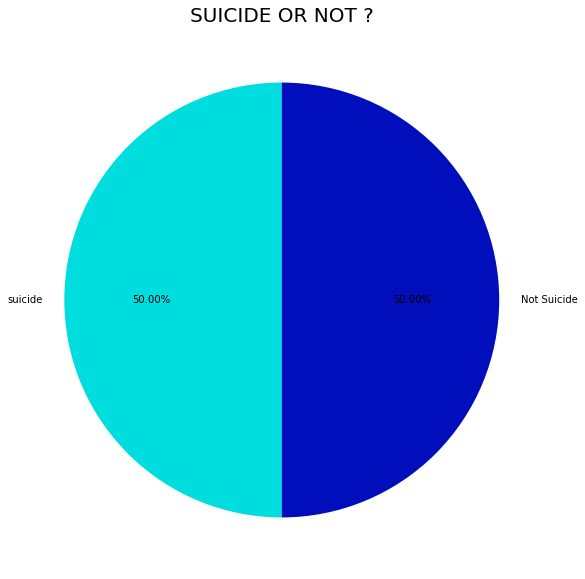

In [62]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

In [21]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', random_state=1)

In [64]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

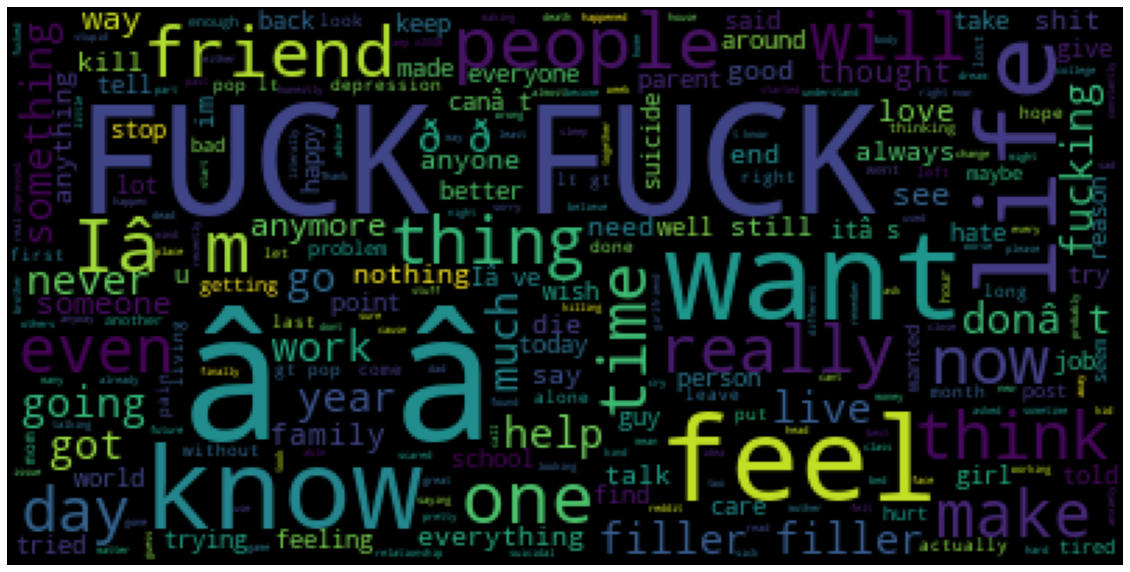

In [72]:
feature_names=Dataset['text'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [68]:
word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

AttributeError: 'function' object has no attribute 'word_counts'

In [22]:
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\(|D|P)',text.lower())
    text = re.sub('[\W]+', ' ', text.lower())
    text += ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in tokenizer_porter(text) if w not in stop]
    return tokenized

In [23]:
from sklearn.feature_extraction.text import HashingVectorizer
vect = HashingVectorizer(decode_error='ignore', n_features=2**21, 
                         preprocessor=None,tokenizer=tokenizer)

In [24]:
X = Dataset["Suicide_Detection"].to_list()
y = Dataset['class']

In [25]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 test_size=0.20,
                                                 random_state=0)

In [26]:
X_train = vect.transform(X_train)
X_test = vect.transform(X_test)

In [37]:
pip install label

  Created wheel for label: filename=label-0.1.1-py3-none-any.whl size=2362 sha256=8eddccfdaeb6208300e52ceaac0dbf2b7d11dd0cd43d6c84fbf9c43cdedf9179
  Stored in directory: c:\users\mayowa\appdata\local\pip\cache\wheels\bc\7e\0b\4e1e1d206046dc892b50931c83e538fa88a6c9064354b3facf
Successfully built label



In [40]:
from sklearn.utils import class_weight
import pandas as pd
import numpy as np

In [44]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train.values.reshape(-1)
)

print(weights)

[0.99912282 1.00087873]


Remove Null Values

In [48]:
Dataset['Suicide_Detection'] =Dataset['Suicide_Detection'].fillna("")

Train Test Split

In [6]:
x_train, x_test, y_train, y_test = train_test_split(Dataset["Suicide_Detection"],Dataset["text"], test_size = 0.33, random_state = 42)   

Count Vectorizer + TFIDF Transformer

Using Count vectorizer combine with TFIDF transformer to convert raw document to tfidf matrix ,as words into binary number

In [7]:
count_vect = CountVectorizer()                        #Convert a collection of text documents to a matrix of token counts
transformer = TfidfTransformer(norm='l2',sublinear_tf=True) 

X_train_counts = count_vect.fit_transform(x_train)
X_train = transformer.fit_transform(X_train_counts)

X_test_counts = count_vect.transform(x_test)
X_test= transformer.transform(X_test_counts)

Train Dataset Shape

In [73]:
print (X_train.shape, y_train.shape)

(185659, 2097152) (185659,)


Test Dataset Shape

In [74]:
print (X_test.shape, y_test.shape)

(46415, 2097152) (46415,)


Machine Learning Model

Using various Machine learning classifiers to Train, Test and Predict and Validate them.

Decision Tree
Using Decision Tree Classifier for Classification and generating the Classification Report.

In [75]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model_1 = tree.DecisionTreeClassifier()
model_1.fit(X_train,y_train)
y_pred1 = model_1.predict(X_test)
pd.DataFrame(                                                
    confusion_matrix(y_test, y_pred1),                      #to check how good is your model prediction
    columns=['True Positive', 'True Negative'],
    index=['Predicted Positive', 'Predicted Negative'])

In [76]:
accuracy_score(y_test, y_pred1)                                    #print the accuracy 
print(classification_report(y_test, y_pred1))  

NameError: name 'y_pred1' is not defined

In [ ]:
model_2 = RandomForestClassifier(n_estimators=50, random_state=0)
model_2.fit(X_train,y_train)
y_pred2 = model_2.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test, y_pred2))